In [1326]:
# Importamos las clases que se requieren para manejar los agentes (Agent) y su entorno (Model).
import mesa
# Cada modelo puede contener múltiples agentes.
from mesa import Agent, Model

# Debido a que necesitamos que existe un solo agente por celda, elegimos ''SingleGrid''.
from mesa.space import  SingleGrid

# Con ''RandomActivation'', hacemos que todos los agentes se activen ''al mismo tiempo''.
from mesa.time import RandomActivation

# Haremos uso de ''DataCollector'' para obtener información de cada paso de la simulación.
from mesa.datacollection import DataCollector

# matplotlib lo usaremos crear una animación de cada uno de los pasos del modelo.
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128

# Importamos los siguientes paquetes para el mejor manejo de valores numéricos.
import numpy as np
import pandas as pd

# Definimos otros paquetes que vamos a usar para medir el tiempo de ejecución de nuestro algoritmo.
import time
import datetime
import random
import heapq

In [1327]:
class Door:
    def __init__(self, coord, status, doors):
      self.coord = coord
      self.status = status
      self.doors = doors # Diccionario que mapea las coordenadas de puertas y sus estados

    def openDoor(self):
      if self.status == 'close':
        self.status = 'open'
        print(f"Door at {self.coord} opened.")
      else:
        print("Door is already open or destroyed.")

    def closeDoor(self):
      if self.status == 'open':
        self.status = 'close'
        print(f"Door at {self.coord} closed.")
      else:
        print("Door is already closed or destroyed.")

    # En destroy, las conexiones en el diccionario se retirarían
    def destroyDoor(self):
      if self.status != 'destroyed':
        self.status = 'destroyed'
        print(f"Door at {self.coord} destroyed.")

    def isPassable(self):
      return self.status == 'open' or self.status == 'destroyed'
    
    # Método para verificar si un agente puede pasar a través de la puerta
    def fireFighterDoorMoves(self, agent, destineCoord):
      x, y = self.coord # Coordenada origen
      destineX, destineY = destineCoord # Coordenada destino

      # Verifica si la puerta está en la dirección del movimiento
      if (destineX, destineY) == (x, y) or (x, y) == agent.coord:
        if self.isPassable():
          return True  # La puerta está abierta o destruida, se puede pasar
        else:
          return False  # La puerta está cerrada, no se puede pasar

      # Si la puerta no está en la dirección del movimiento, no interfiere
      return True


In [1328]:
class Wall:
    def __init__(self, arrayWall, coord, dmgPoints, model):
        self.arrayWall = arrayWall #array
        self.coord = coord #tuple
        self.dmgPoints = dmgPoints
        self.model = model
        #self.wallDirection = wallDirection

    # fireFighterMoves(self: current wall, agent: Firefighter, destineCoord: (x, y))
    # If return true, hay una pared, no puede pasar
    # If return false, el bombero puede pasar
    '''
    | ! | - Aqui falta poner que la pared de la celda compartiendo pared, tambien se destruye de su lado.
    '''
    def fireFighterWallMoves(self, agent, destineCoord):
        x, y = self.coord
        # Check if destineCoord is an iterable (like a tuple) or a non-iterable (like an int)
        if isinstance(destineCoord, (list, tuple)):
            destineX, destineY = destineCoord
        else:
            # If destineCoord is not iterable, assume it's an integer and assign it to destineX or destineY
            # For this example, let's assume destineCoord represents destineX, and destineY is unchanged
            destineX = destineCoord
            destineY = y  # Keep the same y-coordinate

        # if < es Left, if == no se mueve x
        if destineX < x:  # Moving left
            if self.arrayWall[3] != "1":
                return False
        elif destineX > x:  # Moving right
            if self.arrayWall[1] != "1":
                return False
        elif destineY < y:  # Moving up
            if self.arrayWall[0] != "1":
                return False
        elif destineY > y:  # Moving down
            if self.arrayWall[2] != "1":
                return False

        return True  # There's a wall, cannot move
    # takeDamage(self: Wall, damage: int, damageDirection: int)
    # Suma daño a la pared y la quita si es destruida
    # Direction [0]:up [1]:Left [2]:Down [3]:Right
    def takeDamage(self, damage, dmgDirection):
        self.dmgPoints[dmgDirection] += damage
        if self.dmgPoints[dmgDirection] == 2:
            self.dmgPoints[dmgDirection] = 0
            self.arrayWall = [int(x) for x in self.arrayWall]  # Convert all elements to integers
            self.arrayWall[dmgDirection] = 0  # Assign 0 to the specific direction
            self.model.dmgPoints += 1
            print("Wall has been destroyed")
            # Para contador de cuántas paredes han sido destruidas
            return 1
        else:
            self.model.dmgPoints += 1
            print("Wall took 1 of damage")
            # Para contador de cuántas paredes han sido destruidas
            return 0

{(0, 2): [(0, 3), 'close'], (0, 3): [(0, 2), 'close'], (1, 4): [(1, 5), 'close'], (1, 5): [(1, 4), 'close'], (2, 1): [(2, 2), 'close'], (2, 2): [(2, 1), 'close'], (1, 7): [(2, 7), 'close'], (2, 7): [(1, 7), 'close'], (3, 3): [(4, 3), 'close'], (4, 3): [(3, 3), 'close'], (3, 5): [(3, 6), 'close'], (3, 6): [(3, 5), 'close'], (5, 4): [(5, 5), 'close'], (5, 5): [(5, 4), 'close'], (5, 6): [(5, 7), 'close'], (5, 7): [(5, 6), 'close']}


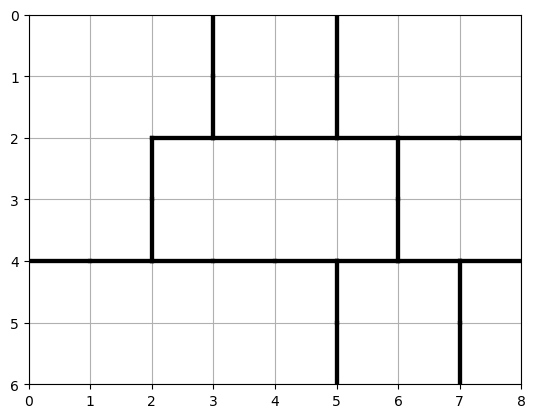

[[None, None, None, None, None, None, None, None], [None, 'F', 'F', 'V', None, None, None, None], [None, 'F', 'F', 'F', 'F', None, None, None], [None, None, None, 'F', None, None, None, None], ['FA', None, None, None, None, 'F', 'F', 'V'], [None, None, None, None, None, 'F', None, None]]


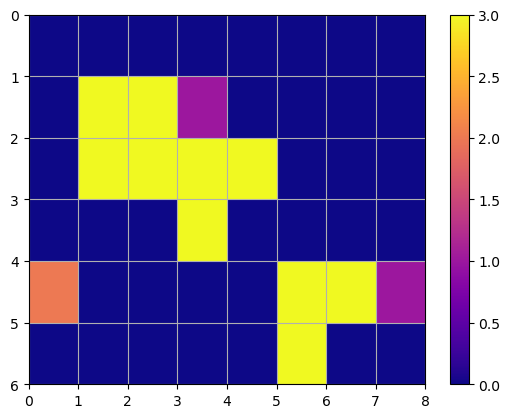

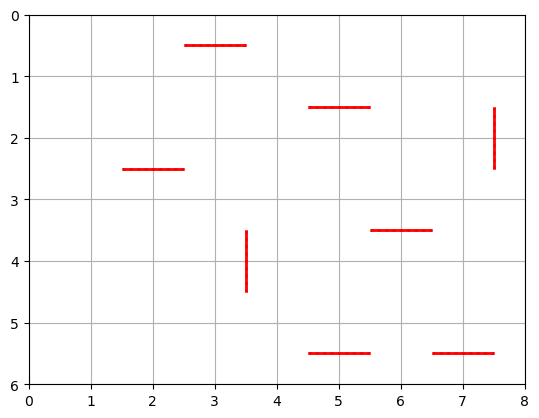

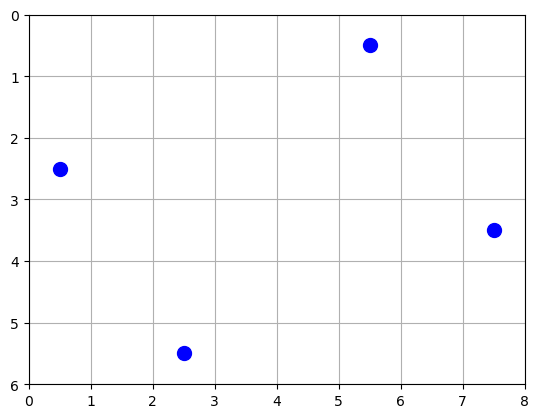

In [1329]:
wallData = []
FirePOI = []
doors = {}
entryPoints = []

with open('wallOpen.txt', 'r') as file:
    sections = file.read().strip().split('\n\n')

    for line in sections[0].strip().split('\n'):
        wallData.append(line.split())

    for line in sections[1].strip().split('\n'):
        FirePOI.append([None if val == 'None' else val for val in line.split()])

# Modificar DOORS AHHH
    # Procesar el contenido línea por línea
    for line in sections[2].strip().split('\n'):
        key, value = line.split(': ')
        key = eval(key)  # Convertir la cadena a una tupla
        value = eval(value)  # Convertir la cadena a una lista con tupla y cadena
        doors[key] = value

    # Mostrar el diccionario resultante
    print(doors)


    for line in sections[3].strip().split('\n'):
        # Split the line into components
        parts = line.split()
        # Clean the strings and convert to integers
        x = int(parts[0].strip('(),'))
        y = int(parts[1].strip('(),'))
        # Append as a tuple
        entryPoints.append((x, y))


dmgPoints = [['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
             ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
             ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
             ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
             ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
             ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000']]

# Las puertas consisten en conexiones entre indices de los diccionarios acorde al tablero
# Las posiciones inician en 0 para seguir el estándar de la matriz WallData

# Los puntos de entrada consisten en celdas junto a un punto de entrada en el tablero
# Las posiciones inician en 0 para seguir el estándar de la matriz WallData

wall_fires = []

for i in range(len(wallData)):
  for j in range(len(wallData[i])):
    if (FirePOI[i][j] == "F" or FirePOI[i][j] == "S") and '1' in wallData[i][j]:
      wall_fires.append((i, j))


rows = len(wallData)
cols = len(wallData[0])

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Configurar los límites del grid
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.grid()

# Dibujar las paredes según los valores en wallData
#matplotlib.rcParams['linewidth'] = 2
for i in range(0, rows):
    for j in range(0, cols):
        cell = wallData[i][j]
        if cell[0] == "1":  # Pared al norte
            ax.plot([j, j + 1], [i, i], 'k-', linewidth=3)
        if cell[1] == "1":  # Pared al este
            ax.plot([j + 1, j + 1], [i, i + 1], 'k-', linewidth=3)
        if cell[2] == "1":  # Pared al sur
            ax.plot([j, j + 1], [i + 1, i + 1], 'k-', linewidth=3)
        if cell[3] == "1":  # Pared al oeste
            ax.plot([j, j], [i, i + 1], 'k-', linewidth=3)
    
# Ajustar la visualización
ax.set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()


# Graficar FirePOI
rowsFirePOI = len(FirePOI)
colsFirePOI = len(FirePOI[0])

# Crear la figura y los ejes
fig, ax = plt.subplots()

# Configurar los límites del grid
ax.set_xlim(0, colsFirePOI)
ax.set_ylim(0, rowsFirePOI)
ax.grid()
print(FirePOI)
FirePOIMatrix = np.zeros((rowsFirePOI, colsFirePOI))
# Dibujar el fuego y POIs 
for i in range(rowsFirePOI):
    for j in range(colsFirePOI):
      cell = FirePOI[i][j]
      if cell == "F": # Celda con fuego
        FirePOIMatrix[i, j] = 3
      elif cell == "FA": # Celda con falsa alarma
        FirePOIMatrix[i, j] = 2
      elif cell == "V": # Celda con víctima
        FirePOIMatrix[i, j] = 1

plt.pcolormesh(FirePOIMatrix, cmap='plasma')
plt.colorbar()
plt.gca().invert_yaxis()
plt.show()


# Graficar las puertas
for key, value in doors.items():
    y1, x1 = key
    (y2, x2), status = value

    
    # Ajustar las posiciones para graficar las puertas en el centro de las celdas
    x1_center = x1 + 0.5
    y1_center = y1 + 0.5
    x2_center = x2 + 0.5
    y2_center = y2 + 0.5

    # Determinar el color y estilo de la línea según el estado de la puerta
    if status == 'close':
        color = 'red'  # Puertas cerradas en rojo
        linestyle = '--'  # Línea discontinua
    else:
        color = 'green'  # Puertas abiertas en verde (u otro estado)
        linestyle = '-'  # Línea continua

    # Dibujar puertas como lineas verdes entre celdas conectadas
    plt.plot([x1_center, x2_center], [y1_center, y2_center], color=color, linestyle=linestyle, linewidth=2)

plt.xlim(0, cols)
plt.ylim(0, rows)
ax.set_aspect('equal')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()


# Graficar los puntos de entrada
#CAMBIAR A ARREGLO
for i in range(0, len(entryPoints)):
      x_center = entryPoints[i][1] + 0.5
      y_center = entryPoints[i][0] + 0.5
      plt.plot(x_center, y_center, 'bo', markersize=10)  # Punto azul para entrada

plt.xlim(0, cols)
plt.ylim(0, rows)
ax.set_aspect('equal')
plt.grid(True)
plt.gca().invert_yaxis()
plt.show()

# Grafica con los elementos unidos

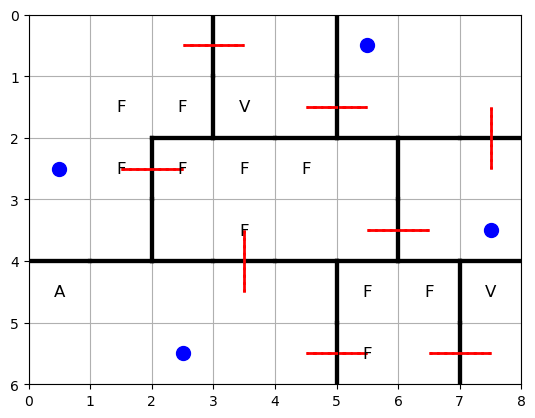

In [1330]:
# Crear la figura y los ejes
fig, ax = plt.subplots()

# Configurar los límites del grid
ax.set_xlim(0, cols)
ax.set_ylim(0, rows)
ax.grid()

# Dibujar las paredes y puertas en el mismo bucle
for i in range(0, rows):
    for j in range(0, cols):
        cell = wallData[i][j]

        # Dibujar las paredes
        if cell[0] == "1":  # Pared al norte
            ax.plot([j, j + 1], [i, i], 'k-', linewidth=3)
        if cell[1] == "1":  # Pared al este
            ax.plot([j + 1, j + 1], [i, i + 1], 'k-', linewidth=3)
        if cell[2] == "1":  # Pared al sur
            ax.plot([j, j + 1], [i + 1, i + 1], 'k-', linewidth=3)
        if cell[3] == "1":  # Pared al oeste
            ax.plot([j, j], [i, i + 1], 'k-', linewidth=3)

        # Dibujar puertas si la celda actual tiene una
        # Al rows y colums, lo que significa que en cartesianas, x e y se invierten
        if (i, j) in doors:
            y1, x1 = i, j
            (y2, x2), status = doors[(i, j)]

            # Ajustar las posiciones para graficar las puertas en el centro de las celdas
            x1_center = x1 + 0.5
            y1_center = y1 + 0.5
            x2_center = x2 + 0.5
            y2_center = y2 + 0.5

             # Determinar el color y estilo de la línea según el estado de la puerta
            if status == 'close':
                color = 'red'  # Puertas cerradas en rojo
                linestyle = '--'  # Línea discontinua
            else:
                color = 'green'  # Puertas abiertas en verde (u otro estado)
                linestyle = '-'  # Línea continua

            # Dibujar puertas como líneas entre celdas conectadas
            plt.plot([x1_center, x2_center], [y1_center, y2_center], color=color, linestyle=linestyle, linewidth=2)

        

        # Dibujar FirePOI en la celda
        if FirePOI[i][j] is not None:
            x_center = j + 0.5
            y_center = i + 0.5

            if FirePOI[i][j] == "F":
                plt.text(x_center, y_center, "F", ha='center', va='center', fontsize=12)
            elif FirePOI[i][j] == "V":
                plt.text(x_center, y_center, "V", ha='center', va='center', fontsize=12)
            elif FirePOI[i][j] == "FA":
                plt.text(x_center, y_center, "A", ha='center', va='center', fontsize=12)

# Graficar los puntos de entrada
# Se lee utilizando rows y colums, lo que significa que en cartesianas, x e y se invierten
for i in range(0, len(entryPoints)):
      x_center = entryPoints[i][1] + 0.5
      y_center = entryPoints[i][0] + 0.5
      plt.plot(x_center, y_center, 'bo', markersize=10)  # Punto azul para entrada

# Ajustar la visualización
ax.set_aspect('equal')
plt.gca().invert_yaxis()
plt.show()

# Lista de Pendientes
- Recoger victima despues de hacer una acción donde la baja.
- Checar array de las Doors para axeWall()
- interactDoor()
- Poner dirección con directionAgent para axeWall()
- def takeVictim(self) ✅

In [1331]:
class FireFighterAgent(Agent):
    def __init__(self, id, Model, actionPoints, victims):
        super().__init__(id, Model)
        self.actionPoints = actionPoints
        self.victims = victims
        self.knockOut = False
        #self.memoryVictim = 0 #Recordar si bajo a una victima, antes de moverse
        self.actionFirefighter = 'firefight' # Accion actual del agente
        self.carrying_victim = False  # To track if the firefighter is carrying a victim
    
    def setAction(self, actionFirefighter):
      # Metodo para cambiar la accion de agente
      self.actionFirefighter = actionFirefighter

    def step(self):
        if self.actionPoints <= 0:
            return  # No action if there are no action points left
        print("EXECUTE STRATEGY")
        self.execute_strategy()
    
    ### ----- MOVEMENT OF AGENT ----- ###
    def dijkstra(self, start, targets):
        # Initialize distances and previous nodes
        print(f"Targets: {targets}")
        distances = {cell: float('inf') for cell in self.model.grid.coord_iter()}
        distances[start] = 0
        priority_queue = [(0, start)]  # (distance, cell)
        visited = set()

        while priority_queue:
            current_distance, current_cell = heapq.heappop(priority_queue)
            # Print the current cell and its distance
            print(f"Current cell: {current_cell}, Distance: {current_distance}")
                #return current_cell, distances[current_cell]

            if current_cell in visited:
                continue

            visited.add(current_cell)

            if current_cell in targets:
                # Return the path to the target found
                print(f"Reached target {current_cell} with distance {distances[current_cell]}")
                return current_cell, distances[current_cell]

            neighbors = self.model.grid.get_neighborhood(current_cell, moore=False, include_center=False)
            for neighbor in neighbors:
                if neighbor not in visited:
                    # Ensure neighbor is within valid grid bounds
                    if not (0 <= neighbor[0] < self.model.grid.width and 0 <= neighbor[1] < self.model.grid.height):
                        continue  # Skip invalid neighbors

                    direction = self.get_direction(current_cell, neighbor)
                    # Check for walls and doors
                    print('CAN MOVE TEST----')
                    can_move = self.move_wall(neighbor) and \
                               self.move_door(neighbor) and \
                               self.check_fire(neighbor)

                    if can_move:
                        #and self.model.grid.is_cell_empty(neighbor):
                        distance = current_distance + 1  # Assuming all edges have the same weight
                        print(f"Evaluating neighbor {neighbor} with distance {distance}")
                        print(distances.items())
                        #key = (self, neighbor)
                        current_neighbor_distance = distances.get((neighbor, self), float('inf'))

                        # Ensure that you only compare when current_neighbor_distance is not None
                        if current_neighbor_distance is not None:
                        #if distances.get(neighbor, None) != 0:
                            print("distances on nieghbor")
                            print(distances.get(neighbor, None))
                            print(distances.get(neighbor, self))
                            if distance < current_neighbor_distance:
                                print('DISTANCE = DISTANCES')
                                distances[neighbor] = distance
                                heapq.heappush(priority_queue, (distance, neighbor))
                                # Print when adding a neighbor to the priority queue
                                print(f"Adding neighbor {neighbor} to the queue with distance {distances[neighbor]}")



        return None, float('inf')  # No path found

    
    def get_direction(self, current, neighbor):
        # Determine direction from current cell to neighbor
        cx, cy = current
        nx, ny = neighbor
        if nx < cx:  # Moving up
            return 0
        elif nx > cx:  # Moving down
            return 2
        elif ny < cy:  # Moving left
            return 1
        elif ny > cy:  # Moving right
            return 3

    def check_fire(self, neighbor):
        # Avoid cells on fire if carrying a victim
        if self.carrying_victim:
            x, y = neighbor
            fire_poi = self.model.FirePOI[y][x]
            if fire_poi == 'F':
                print(f"Agent {self.unique_id} avoiding fire at {neighbor} while carrying a victim.")
                return False
        return True
    
    def find_and_move(self, targets):
        print(targets)
        target, distance = self.dijkstra(self.pos, targets)
        print(target)
        if target:
            print('MOVE')
            self.move(self.model.wallData, target)
            print(f"Agente {self.unique_id} se movió hacia {target}")
        else:
            print('NO NOVE')
            print(f"Agente {self.unique_id} no encontró un camino a las víctimas o FA")
            self.move_randomly()

    def move_randomly(self):
      #Selecciona un vecino aleatorio y trata de moverse hacia allí.
      neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
      print(f"Vecinos disponibles para el agente {self.unique_id}: {neighbors}")
      possible_moves = [neighbor for neighbor in neighbors if self.model.grid.is_cell_empty(neighbor)]

      if possible_moves:
          destineCoord = random.choice(possible_moves)
          print(f"Agente {self.unique_id} intenta moverse a {destineCoord}")
          success = self.move(self.model.wallData, destineCoord)
          return success
      return False

    def move_wall(self, destineCoord):
        current_wall = next(
            (wall for wall in self.model.walls if wall.coord == self.pos), None
        )
        if current_wall:
            if not current_wall.fireFighterWallMoves(self, destineCoord):
                return True
            else:
                print(
                    f"Agent {self.unique_id} could not move to {destineCoord}. Blocked by a wall"
                )
                return False
        else:
            print(f"No wall found at {self.pos}")
            return True
    
    def move_door(self, destineCoord):
        current_door = next(
            (door for door in self.model.doors.items() if door[1] == self.pos), None
        )
        print(f"Door: {current_door}")
        if current_door:
            if current_door.fireFighterDoorMoves(self, destineCoord):
                return True
            else:
                print(
                    f"Agent {self.unique_id} could not move to {destineCoord}. Blocked by a closed door"
                )
                return False
        else:
            print(f"No door found at {self.pos}")
            return True
        
    def move(self, wallData, destineCoord):
      # Intenta mover el agente a la coordenada destino.
        if not self.model.grid.is_cell_empty(destineCoord):
            print("False")
            return False
        if 0 <= destineCoord[0] < len(wallData[0]) and 0 <= destineCoord[1] < len(wallData):          # Find the Wall object corresponding to the agent's current position
                    if self.move_wall(destineCoord):
                        if self.move_door(destineCoord):                        
                            self.model.grid.move_agent(self, destineCoord)
                            print(f"#####Agent {self.unique_id} moved to {destineCoord}######")
                            return True
                

        else:
            print(f"Agent {self.unique_id} is at an invalid position: {self.pos}")
            return False
        
    ###---AGENT ACTIONS---###
    def knockOut(self, exitCoord, vicitmsLostCount):
        self.knockOut = True
        if self.carrying_victim == 1:
            self.carrying_victim == 0
            victimsLostCount += 1
        self.coord = None
        return victimsLostCount
    
    def axeWall(self, FirePOI, Wall, axeDirection):
        if self.carrying_victim == 1:
            self.carrying_victim == 0
            self.firePOI[self.pos] = 'V'
            # | ! | - No puede estar cargando con la víctima cuando destruye la pared 
        Wall.takeDamage(1, axeDirection)
        
    def leaveVicitm(self, FirePOI):
        if FirePOI[self.pos] == None:
            self.actionPoints -= 1
            self.carrying_victim = 0
            self.memoryVictim = 1
            print(f'Se deja la víctima: Agent #{self.unique_id}')
            print(f'Agent #{self.unique_id} now has {self.actionPoints} left')
        else:
            print(f'No se puede poner víctima: Agent #{self.unique_id}')
            return False         

    def takeVictim(self):
        x, y = self.pos
        if self.model.FirePOI[y][x] == 'V':
            if self.carrying_victim == 0:
                self.carrying_victim = 1
                print(f'Recoge víctima: Agent #{self.unique_id}')
            else:
                self.actionPoints -= 1
                print(f'Ya carga con una víctima: Agent #{self.unique_id}')
                print(f'Agent #{self.unique_id} now has {self.actionPoints} left')
                return False
        else:
            self.actionPoints -= 1
            print(f'Falsa Alarma | No hay una victima aquí: Agent #{self.unique_id}')
            print(f'Agent #{self.unique_id} now has {self.actionPoints} left')
            return False
            
    def interactDoor(self, Door, actionFirefighter):
        if self.carrying_victim == 0:
            if actionFirefighter == 'openDoor':
                if Door.isPassable() == False:
                    self.actionPoints -= 1
                    Door.openDoor()
                    print(f"Opens door: Agent #{self.unique_id}")
                    print(f'Agent #{self.unique_id} now has {self.actionPoints} left')
                else:
                    self.actionPoints += 1
                    print(f'Door already open or destroyed: Agent #{self.unique_id}')
                    print(f'Agent #{self.unique_id} now has {self.actionPoints} left')
            if actionFirefighter == 'closeDoor':
                if Door.isPassable() == True: #Open
                    self.actinoPoints -= 1
                    Door.closeDoor()
                    print(f'Agent #{self.unique_id} now has {self.actionPoints} left')
                else:
                    self.actionPoints += 1
                    print(f'Door already closed: Agent #{self.unique_id}')
                    print(f'Agent #{self.unique_id} now has {self.actionPoints} left')
        else:
            self.leaveVcitim(FirePOI)

    def extinguishFire(self, FirePOI, firePos):
        x, y = firePos
        if FirePOI[y][x] == 'F':
            self.actionPoints -= 1
            FirePOI[y][x] = 'S'
            print(f"Extingue Fuego el Agente #{self.unique_id}")
            print(f'Agent #{self.unique_id} now has {self.actionPoints} left')
        elif FirePOI[y][x] == 'S':
            self.actionPoints -= 1
            FirePOI[y][x] = None
            print(f"Extingue Humo el Agente #{self.unique_id}")
            print(f'Agent #{self.unique_id} now has {self.actionPoints} left')
        else:
            self.actionPoints += 1
            print(f"***No se necesita Extinguir: Agente #{self.unique_id} ***")
            print(f'Agent #{self.unique_id} now has {self.actionPoints} left')
            return    
    
    ###---- AGENT STRATEGY -----###
    def execute_strategy(self):
        # Implementing the strategy
        if self.fire_next_to_wall():
            print('FIRE FIRST')
            self.prioritize_extinguishing()
        elif self.victim_in_cell():
            print('TAKE VICTIM')
            self.takeVictim()
            self.carry_to_exit()
        elif self.should_switch_role():
            print('SWITCH ROLE')
            self.switch_role()
        else:
            print('LAST OPTION')
            self.firefight_or_rescue()
    def flatten_coords(coord):
        # Convert a tuple (x, y) to a single integer
        x, y = coord
        return int(f"{x}{y}")

    def fire_next_to_wall(self):
        print('1')
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        print(f'FIREPOI: {self.model.FirePOI}')
        print(f'Neighbors: {neighbors}')
        if neighbors:
            print('MADE IT')
            for neighbor in neighbors:
                x, y = neighbor  # Since neighbor is a tuple (x, y)
                # Check if there's a fire ('F') at the neighbor's position and if the wall allows movement
                if self.model.FirePOI[y][x] == 'F' and self.move_wall(neighbor):
                    return True
                else:
                    return False
            return False
        else:
            return False
    
    def prioritize_extinguishing(self):
        print('2')
        neighbors = self.model.grid.get_neighborhood(self.pos, moore=False, include_center=False)
        if neighbors:
            for neighbor in neighbors:
                x, y = neighbor
                if self.model.FirePOI[y][x] == 'F':
                    self.extinguishFire(self.model.FirePOI, neighbor)
                    return
        else:
            return
    def victim_in_cell(self):
        x, y = self.pos
        return self.model.FirePOI[y][x] == 'V'


    def carry_to_exit(self):
        if self.carrying_victim == 1:
            exit_points = self.model.entryPoints
            self.find_and_move(exit_points)

    def should_switch_role(self):
        return self.unique_id in [1, 3, 5] and self.model.step_count % 2 == 0

    def switch_role(self):
        if self.actionFirefighter == 'rescue':
            self.setAction('firefight')
        else:
            self.setAction('rescue')

    def firefight_or_rescue(self):
        if self.actionFirefighter == 'firefight':
            self.prioritize_extinguishing()
        else:
            self.rescue()

    def rescue(self):
        if self.victim_in_cell():
            self.takeVictim()
        else:
            print('FIND AND MOVE')
            print(self.model.currentPoiCoord)
            self.find_and_move(self.model.currentPoiCoord)

    def open_door(self):
        doors = self.model.get_doors_near(self.pos)
        for door in doors:
            self.interactDoor(door, 'openDoor')

    def close_door(self):
        doors = self.model.get_doors_near(self.pos)
        for door in doors:
            self.interactDoor(door, 'closeDoor')

In [1332]:
def get_grid(model):
  grid = np.zeros((model.grid.height, model.grid.width))
  for x in range(model.width):
    for y in range(model.height):
      cell_content = model.FirePOI[y][x]
      if cell_content == "F":
          grid[y, x] = 1
      elif cell_content == "FA":
          grid[y, x] = 2
      elif cell_content == "V":
          grid[y, x] = 3
      elif cell_content == "S":
          grid[y, x] = 4

  for agent in model.schedule.agents:
    x, y = agent.pos
    grid[y, x] = 5

  return grid

In [1333]:
class FireModel(Model):
  def __init__(self, wallData, doors, entryPoints, FirePOI, firefighters):
    super().__init__()
    self.firefighters = firefighters
    self.width = len(wallData[0])
    self.height = len(wallData)
    self.wallData = wallData
    self.doors = doors
    self.entryPoints = entryPoints
    self.FirePOI = FirePOI
    self.victimsCount = 0
    self.falseAlarmCount = 0
    self.victimsLostCount = 0
    self.dmgPoints = 0
    self.step_count = 0
    self.walls = [] # Lista para mantener las paredes
    self.currentPoiCoord = [(2, 4), (5, 1), (5, 8)]
    self.grid = SingleGrid(self.width, self.height, torus=False)
    self.schedule = RandomActivation(self)

    self.initializeGrid()

    # Recolectores de datos
    self.datacollector = DataCollector({"Grid": get_grid})

    self.placeAgents()

  def placeAgents(self):
    # Añadir bomberos en posiciones aleatorias
    for i in range(self.firefighters):
      agent = FireFighterAgent(i, self, 10, 0)
      self.grid.move_to_empty(agent)
      self.schedule.add(agent)
      print(f"Agente {i} colocado en {agent.pos}")

  def initializeGrid(self):
    for y in range(self.height):
      for x in range(self.width):
        cell = self.wallData[y][x]
        wall = Wall(cell, (x, y), [0, 0, 0, 0], self)
        self.walls.append(wall)
    for coord, value in self.doors.items():
      (connected_coord, status) = value 
      door = Door(coord, status, self.doors) 
      self.doors[coord] = (connected_coord, door) # Guardar como una tupla 

  def dice(self):
    x = random.randint(1, 8)
    y = random.randint(1, 6)
    return x, y

  def spreadFire(self):
    x, y = self.dice()
    target = self.FirePOI[y - 1][x - 1]
    
    if target is None:
      self.FirePOI[y - 1][x - 1] = "S" # S representa humo
    elif target == "S":
      self.FirePOI[y - 1][x - 1] = "F" # Humo se convierte en fuego
    elif target == "V":
      self.FirePOI[y - 1][x - 1] = "S" # La celda se convierte en humo y la victima se pierde
      self.victimsLostCount += 1
    elif target == "FA":
      self.FirePOI[y - 1][x - 1] = "S" # Falsa alarma se convierte en humo
    elif target == "F":
      self.explosion(x - 1, y - 1) # Ocurre una explosion

  # Aqui va la logica cuando ocurre una explosion
  def explosion(self, x, y):
    print(f"explosion en la posicion ({x+1}, {y+1})")
    
    # Importante: x son las columnas/colums, y son las filas/rows
    directions = {
      'up': (x, y + 1),
      'down': (x, y - 1),
      'left': (x - 1, y),
      'right': (x + 1, y)
    }
    # La celda original es fuego
    self.FirePOI[y][x] = "F"

    for direction, (adjX, adjY) in directions.items():
      if 0 <= adjX < self.width and 0 <= adjY < self.height:
        # Manejo de FirePOI
        if self.FirePOI[adjY][adjX] == "V":
            self.FirePOI[adjY][adjX] = "S"
            self.victimsLostCount += 1
        elif self.FirePOI[adjY][adjX] == "FA":
            self.FirePOI[adjY][adjX] = "S"
        elif self.FirePOI[adjY][adjX] is None:
            self.FirePOI[adjY][adjX] = "S"
        elif self.FirePOI[adjY][adjX] == "F":
            self.shockwave(adjX, adjY, direction) # Se produce una onda de choque


        # Manejo de paredes
        for wall in self.walls:
          if wall.coord == (adjX, adjY):
            if direction == 'up':
              wall.takeDamage(1, 0)  # Daño hacia arriba
            elif direction == 'down':
              wall.takeDamage(1, 2)  # Daño hacia abajo
            elif direction == 'left':
              wall.takeDamage(1, 3)  # Daño hacia la izquierda
            elif direction == 'right':
              wall.takeDamage(1, 1)  # Daño hacia la derecha

        # Manejo de puertas
        if (adjX, adjY) in self.doors:
          door = self.doors[(adjX, adjY)][1]
          door.destroyDoor()
    

  def shockwave(self, x, y, direction):
    # Importante: x son las columnas/colums, y son las filas/rows
    print(f"shockwave en la posición ({x+1}, {y+1}) en dirección {direction}")

    # Direccion de movimiento de la onda de choque
    directions = {
      'up': (0, 1),
      'down': (0, -1),
      'left': (-1, 0),
      'right': (1, 0)
    }

    # Inicializar la posición actual
    dx, dy = directions[direction]
    current_x, current_y = x + dx, y + dy

    # Bucle para propagar la onda de choque
    while 0 <= current_x < self.width and 0 <= current_y < self.height:
      # Verificar la celda actual
      if self.FirePOI[current_y][current_x] in [None, "S", "V", "FA"]:
        # Si es una celda vacía, con humo, víctima o falsa alarma, se convierte en fuego detiene la onda de choque
        self.FirePOI[current_y][current_x] = "F"
        print(f"Onda de choque detenida en posición ({current_x+1}, {current_y+1})")
        return

      elif self.FirePOI[current_y][current_x] == "F":
        # Si hay fuego, propaga la onda de choque
        self.FirePOI[current_y][current_x] = "F"
        print(f"Onda de choque se propaga en posición ({current_x+1}, {current_y+1})")
      
      # Manejo de puertas
      if (current_x, current_y) in self.doors:
        door = self.doors[(current_x, current_y)][1]
        door.destroyDoor()
        print(f"Puerta destruida en posición ({current_x+1}, {current_y+1})")
        return
      
      # Manejo de paredes
      for wall in self.walls:
        if wall.coord == (current_x, current_y):
          if direction == 'up':
            wall.takeDamage(1, 0)  # Daño hacia arriba
          elif direction == 'down':
            wall.takeDamage(1, 2)  # Daño hacia abajo
          elif direction == 'left':
            wall.takeDamage(1, 3)  # Daño hacia la izquierda
          elif direction == 'right':
            wall.takeDamage(1, 1)  # Daño hacia la derecha
          print(f"Pared dañada/destruida en posición ({current_x+1}, {current_y+1})")
          return

      # Avanza a la siguiente celda en la dirección de la onda de choque
      current_x += dx
      current_y += dy

  def ensureThreePOIs(self):
      currentPoiCount = sum(1 for row in self.FirePOI for cell in row if cell in ["V", "FA", "F"])
      #self.currentPoiCoord = []
      if self.currentPoiCoord > 3:
        self.currentPoiCoord.pop() 
      while currentPoiCount < 3:
        x, y = self.dice()
        
        if self.FirePOI[y][x] is None or self.FirePOI[y][x] not in ["V", "FA", "F"]:
          # Coloca un nuevo POI en una posición aleatoria
          if random.random() < 0.5:
            self.FirePOI[y][x] = "V"  # Víctima
            self.currentPoiCoord.append((x, y))
            #print(self.currentPoiCoord)
            print(f"Nuevo punto de interés (Víctima) en posición ({x+1}, {y+1})")
          else:
            self.FirePOI[y][x] = "FA"  # Falsa alarma
            self.currentPoiCoord.append((x, y))
            #print(self.currentPoiCoord)
            print(f"Nuevo punto de interés (Falsa Alarma) en posición ({x+1}, {y+1})")
  
  def checkEndCondition(self):
    if self.dmgPoints >= 24:
      print("Simulación terminada: La mayoría de las paredes fueron destruidas.")
      return True
    elif self.victimsLostCount >= 6:
      print("Simulación terminada: Se perdieron demasiadas víctimas.")
      return True
    return False

  def visualize_grid(self):
    grid_data = self.datacollector.get_model_vars_dataframe()["Grid"].values[-1]

    # Crear la figura y los ejes
    fig, ax = plt.subplots()

    # Configurar los límites del grid
    ax.set_xlim(0, self.width)
    ax.set_ylim(0, self.height)
    ax.grid()

    # Dibujar las paredes, puertas y FirePOI en el mismo bucle
    for i in range(self.height):
        for j in range(self.width):
            cell = self.wallData[i][j]

            # Dibujar las paredes
            if cell[0] == "1":  # Pared al norte
                ax.plot([j, j + 1], [i, i], 'k-', linewidth=3)
            if cell[1] == "1":  # Pared al este
                ax.plot([j + 1, j + 1], [i, i + 1], 'k-', linewidth=3)
            if cell[2] == "1":  # Pared al sur
                ax.plot([j, j + 1], [i + 1, i + 1], 'k-', linewidth=3)
            if cell[3] == "1":  # Pared al oeste
                ax.plot([j, j], [i, i + 1], 'k-', linewidth=3)

            # Dibujar puertas si la celda actual tiene una
            if (i, j) in self.doors:
                y1, x1 = i, j
                (y2, x2), status = doors[(i, j)]

                # Ajustar las posiciones para graficar las puertas en el centro de las celdas
                x1_center = x1 + 0.5
                y1_center = y1 + 0.5
                x2_center = x2 + 0.5
                y2_center = y2 + 0.5

                # Determinar el color y estilo de la línea según el estado de la puerta
                if status == 'close':
                    color = 'red'  # Puertas cerradas en rojo
                    linestyle = '--'  # Línea discontinua
                else:
                    color = 'green'  # Puertas abiertas en verde (u otro estado)
                    linestyle = '-'  # Línea continua

                # Dibujar puertas como líneas entre celdas conectadas
                plt.plot([x1_center, x2_center], [y1_center, y2_center], color=color, linestyle=linestyle, linewidth=2)

            # Dibujar FirePOI en la celda
            if self.FirePOI[i][j] is not None:
                x_center = j + 0.5
                y_center = i + 0.5

                if self.FirePOI[i][j] == "F":
                    ax.text(x_center, y_center, "F", ha='center', va='center', fontsize=12)
                elif self.FirePOI[i][j] == "V":
                    ax.text(x_center, y_center, "V", ha='center', va='center', fontsize=12)
                elif self.FirePOI[i][j] == "FA":
                    ax.text(x_center, y_center, "A", ha='center', va='center', fontsize=12)

    # Dibujar los agentes (firefighters)
    for agent in self.schedule.agents:
        x_center = agent.pos[1] + 0.5  # Convertir coordenadas del grid a coordenadas gráficas
        y_center = agent.pos[0] + 0.5
        ax.plot(x_center, y_center, 'ro', markersize=10)  # Dibujar como un punto rojo

    # Graficar los puntos de entrada
    for i in range(0, len(entryPoints)):
      x_center = entryPoints[i][1] + 0.5
      y_center = entryPoints[i][0] + 0.5
      plt.plot(x_center, y_center, 'bo', markersize=10)  # Punto azul para entrada

    # Ajustar la visualización
    ax.set_aspect('equal')
    plt.gca().invert_yaxis()
    plt.show()
    print(f"arrayWall: {[wall.arrayWall for wall in model.walls]}")
    print(f"doors: {model.doors}")



  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()
    self.spreadFire() # Al final de cada turno, los dados se tiran
    self.step_count += 1


In [1334]:
# Funcion para cargar la configuracion del archivo de texto nuevamente
def loadData(filename):
        wallData = []
        FirePOI = []
        doors = {}
        entryPoints = []
        dmgPoints = [['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
                     ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
                     ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
                     ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
                     ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000'],
                     ['0000', '0000', '0000', '0000', '0000', '0000', '0000', '0000']]

        with open(filename, 'r') as file:
            sections = file.read().strip().split('\n\n')

            for line in sections[0].strip().split('\n'):
                wallData.append(line.split())

            for line in sections[1].strip().split('\n'):
                FirePOI.append([None if val == 'None' else val for val in line.split()])

            for line in sections[2].strip().split('\n'):
                key, value = line.split(': ')
                key = eval(key)
                value = eval(value)
                doors[key] = value

            for line in sections[3].strip().split('\n'):
                parts = line.split()
                x = int(parts[0].strip('(),'))
                y = int(parts[1].strip('(),'))
                entryPoints.append((x, y))
        
        return wallData, FirePOI, doors, entryPoints, dmgPoints

Agente 0 colocado en (2, 4)
Agente 1 colocado en (7, 1)
Agente 2 colocado en (5, 5)
Agente 3 colocado en (3, 3)
Agente 4 colocado en (0, 0)
{(0, 2): ((0, 3), <__main__.Door object at 0x000001786F783500>), (0, 3): ((0, 2), <__main__.Door object at 0x00000178631676E0>), (1, 4): ((1, 5), <__main__.Door object at 0x000001786F783050>), (1, 5): ((1, 4), <__main__.Door object at 0x000001786F782F60>), (2, 1): ((2, 2), <__main__.Door object at 0x000001786F783230>), (2, 2): ((2, 1), <__main__.Door object at 0x000001786F7819D0>), (1, 7): ((2, 7), <__main__.Door object at 0x000001786F782CC0>), (2, 7): ((1, 7), <__main__.Door object at 0x000001786F782F30>), (3, 3): ((4, 3), <__main__.Door object at 0x000001786F782ED0>), (4, 3): ((3, 3), <__main__.Door object at 0x000001786F7830E0>), (3, 5): ((3, 6), <__main__.Door object at 0x000001786F783B30>), (3, 6): ((3, 5), <__main__.Door object at 0x000001786F781A60>), (5, 4): ((5, 5), <__main__.Door object at 0x000001786F781C10>), (5, 5): ((5, 4), <__main__.

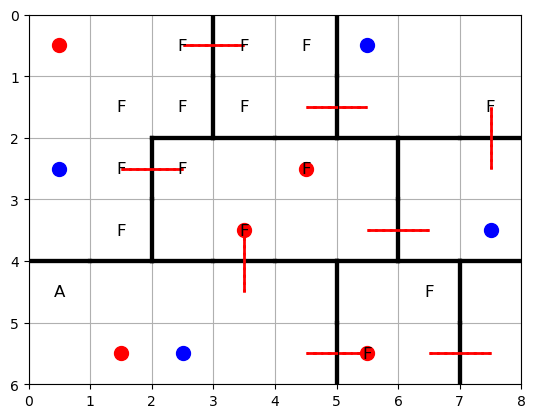

arrayWall: ['0000', '0000', '0100', '0001', '0100', '0001', '0000', '0000', '0000', '0000', '0110', '0011', '0110', '0011', '0010', '0010', '0000', '0100', '1001', [1, 0, 0, 0], '1000', '1100', '1001', '1000', '0010', '0110', [0, 0, 1, 0], '0010', [0, 0, 1, 0], '0110', '0011', '0010', '1000', '1000', '1000', [0, 0, 0, 0], '1100', '1001', '1100', '1001', '0000', '0000', '0000', '0000', '0100', '0001', '0100', '0001']
doors: {(0, 2): ((0, 3), <__main__.Door object at 0x000001786F783500>), (0, 3): ((0, 2), <__main__.Door object at 0x00000178631676E0>), (1, 4): ((1, 5), <__main__.Door object at 0x000001786F783050>), (1, 5): ((1, 4), <__main__.Door object at 0x000001786F782F60>), (2, 1): ((2, 2), <__main__.Door object at 0x000001786F783230>), (2, 2): ((2, 1), <__main__.Door object at 0x000001786F7819D0>), (1, 7): ((2, 7), <__main__.Door object at 0x000001786F782CC0>), (2, 7): ((1, 7), <__main__.Door object at 0x000001786F782F30>), (3, 3): ((4, 3), <__main__.Door object at 0x000001786F782ED0

In [1335]:
FIREFIGHTERS = 5
#WALLDATA = wallData
#DOORS = doors
#ENTRYPOINTS = entryPoints
#FIREPOI = FirePOI
ITERATIONS = 50

WALLDATA, FIREPOI, DOORS, ENTRYPOINTS, DMGPOINTS = loadData('wallOpen.txt')

model = FireModel(WALLDATA, DOORS, ENTRYPOINTS, FIREPOI, FIREFIGHTERS)
print(model.doors)
while not model.checkEndCondition():
    model.step()

model.visualize_grid()


all_grid = model.datacollector.get_model_vars_dataframe()

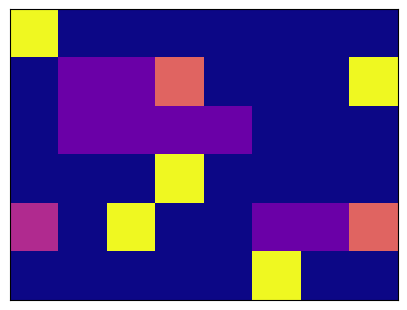

In [1336]:
fig, axs = plt.subplots(figsize=(5, 5))
axs.set_xticks([])
axs.set_yticks([])

# Obtener la primera cuadrícula para inicializar la visualización
cmap = ListedColormap(["white", "darkorange", "yellow", "green"])
first_grid = all_grid.iloc[0]["Grid"]
patch = plt.imshow(first_grid, cmap=plt.cm.plasma)

def animate(i):
   patch.set_data(all_grid.iloc[i]['Grid'])

anim = animation.FuncAnimation(fig, animate, frames=len(all_grid))

In [1337]:
anim